<a href="https://colab.research.google.com/github/zdepablo/Attentive_Convolution/blob/master/News_Vocabulary_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import string

In [0]:
from sklearn import model_selection

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

plt.rcParams["figure.figsize"] = (6,6)

In [0]:
NEWS_TRAIN_PATH = "News_category_train.json"
NEWS_TEST_PATH  = "News_category_test.json"

In [0]:
df = pd.read_json(NEWS_TRAIN_PATH)
df_test = pd.read_json(NEWS_TEST_PATH)

In [5]:
num_instances_train = df.shape[0]
num_instances_test  = df_test.shape[0]

print(df.columns)

print(f"Train dataset size: {num_instances_train}")
print(f"Test  dataset size: {num_instances_test}")

Index(['authors', 'category', 'headline', 'link', 'short_description'], dtype='object')
Train dataset size: 65000
Test  dataset size: 34171


In [0]:
df["id"] = range(0,num_instances_train)
df_test["id"] = range(num_instances_train, num_instances_train + num_instances_test)

In [0]:
X_test, X_valid, Y_test, Y_valid = model_selection.train_test_split(df_test[['id','headline','short_description']],
                                                                    df_test[['id','category']], 
                                                                    test_size=0.5)

In [30]:
print(f"Test shape: {X_test.shape}")
print(f"Valid shape: {X_valid.shape}")

Test shape: (17085, 3)
Valid shape: (17086, 3)


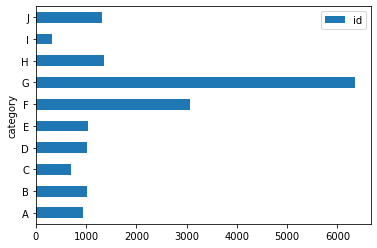

In [34]:
Y_test.groupby('category').count().plot(kind='barh')

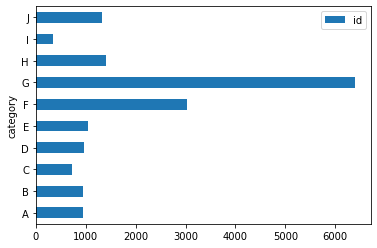

In [35]:
Y_valid.groupby('category').count().plot(kind='barh')

In [0]:
labels = ['A','B','C','D','E','F','G','H','I','J']

In [0]:
headline_vectorizer = CountVectorizer(encoding = 'utf-8',
                             strip_accents ='unicode', 
                             lowercase = True, 
                             stop_words = 'english', 
                             ngram_range =(1,1),
                             min_df = 10,
                             max_df = 0.7,
                             max_features = 10000
                             )


descriptions_vectorizer = CountVectorizer(encoding = 'utf-8',
                             strip_accents ='unicode', 
                             lowercase = True, 
                             stop_words = 'english', 
                             ngram_range =(1,1),
                             min_df = 10,
                             max_df = 0.7,
                             max_features = 5000
                             )


combined_vectorizer = CountVectorizer(encoding = 'utf-8',
                             strip_accents ='unicode', 
                             lowercase = True, 
                             stop_words = 'english', 
                             ngram_range =(1,1),
                             min_df = 10,
                             max_df = 0.7,
                             max_features = 5000
                             )

## 2. Explore headlines vocabulary 

In [40]:
headline_vectorizer.fit(df.headline)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.7, max_features=10000, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_doc_terms = headline_vectorizer.transform(df.headline)

In [0]:
def showFreqTerms(X_train_counts, vectorizer, ):
    sum_words = X_train_counts.sum(axis = 0)

    term_freq = [(word,sum_words[0,idx]) for word,idx in vectorizer.vocabulary_.items()]
    return sorted(term_freq, key = lambda x:x[1], reverse = True)

In [0]:
terms = showFreqTerms(X_doc_terms, headline_vectorizer)
terms_df = pd.DataFrame(terms[0:30], columns = ["term", "frequency"])

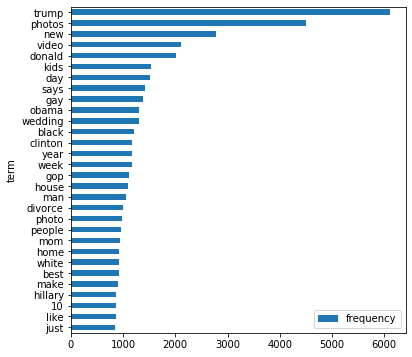

In [46]:
terms_df.set_index("term").sort_values("frequency").plot(kind="barh")

- Common terms like photo/photos, videos and numbers appear. They are probably not very discriminative. 
- Some proper names appear: Trump, Clinton, Sanders which probably reflect the time characteristics of news. Such terms may help to identify news in the same time period but may not be useful in the future or past. 


TODO: Some terms appear in plural/singular form, stemming (in English) would make the classifier something more robust, again value on final metrics may be only incremental. 
TODO: How can we generalize proper names: NER? 


## 2.1 Short Descriptions vocabulary

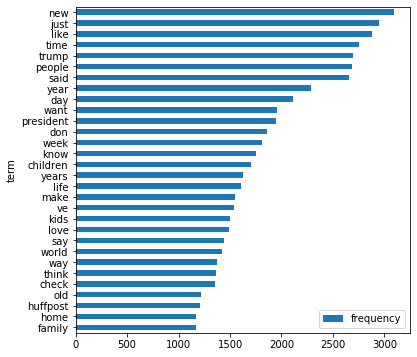

In [47]:
descriptions_vectorizer.fit(df.short_description)
X_doc_terms = descriptions_vectorizer.transform(df.short_description)
description_terms = showFreqTerms(X_doc_terms, descriptions_vectorizer)
description_terms_df = pd.DataFrame(description_terms[0:30], columns = ["term", "frequency"])
description_terms_df.set_index("term").sort_values("frequency").plot(kind="barh")

It seems that short descriptions have some common language that is not filtered by stopwords: (new, like, year, day, week, 've ). 

TODO: Using a customized stopwords list may help make results more robust, though their influence in numbers may be small. 


In [0]:
df["combined"] = df.apply(lambda x: x.headline + " " + x.short_description, axis=1)

In [49]:
df.head(n = 2)


,authors,category,headline,link,short_description,id,combined
0,Priscilla Frank,A,'Rice-Ko' Is What Happens When Artists Recreate Rothko Paintings Using Rice,https://www.huffingtonpost.com/entry/artists-recreate-iconic-rothko-paintings-using-rice_us_57800f90e4b01edea78df08c,And it's all a delicious homage to a 1950s art scandal.,0,'Rice-Ko' Is What Happens When Artists Recreate Rothko Paintings Using Rice And it's all a delicious homage to a 1950s art scandal.
1,"Jocelyn Jeffery, ContributorFounder/Editor-In-Chief of materialist magazine",A,Fragments of Femininity: A Comparative Analysis of the Art of Tracey Emin and Kiki Smith,https://www.huffingtonpost.com/entry/fragments-of-femininity-a_b_6192922.html,"For Smith and Emin, the body is in perpetual motion. Neither artist has any shame in laying the ghastliest aspects of femininity stripped bare. This introspection strips their work of pretense down to an almost primeval level.",1,"Fragments of Femininity: A Comparative Analysis of the Art of Tracey Emin and Kiki Smith For Smith and Emin, the body is in perpetual motion. Neither artist has any shame in laying the ghastliest aspects of femininity stripped bare. This introspection strips their work of pretense down to an almost primeval level."


## 3. Combined text vocabulary. 

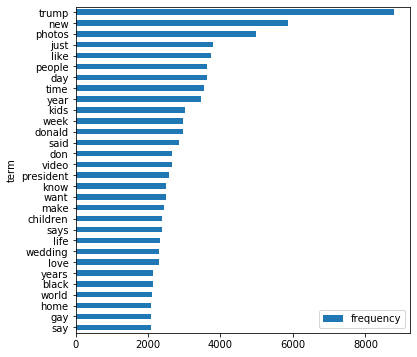

In [50]:
combined_vectorizer.fit(df.combined)
X_doc_terms = combined_vectorizer.transform(df.combined)
combined_terms = showFreqTerms(X_doc_terms, combined_vectorizer)
combined_terms_df = pd.DataFrame(combined_terms[0:30], columns = ["term", "frequency"])
combined_terms_df.set_index("term").sort_values("frequency").plot(kind="barh")

## 4. Explore vocabulary per category

First we look into some headlines, then we try to explore the common vocabulary for a category. From this analysis we expect to understand the category and also if the categories are identifiables. 

In [52]:
for l in labels: 
  print(l)
  print(df.headline[df.category == l].sample(n = 5))
  print()

A
1274    'Sharp Suits': Graphic Designers Mark Shanley and Paddy Treacy Channel Anger Into Hilarious Illustrations Of Clients' Worst Feedback (PHOTOS)
1386    "Age Shall Not Weary Them" - Shakespeare and Memorial Day                                                                                    
1393    Women In Sitcoms Are Getting A Lot More Three-Dimensional. And That's A Good Thing.                                                          
27      Wangechi Mutu on the ImageBlog                                                                                                               
259     These High-Tech Ballet Shoes Demonstrate Just How Explosive Dancers' Movements Can Be                                                        
Name: headline, dtype: object

B
2897    The Best Night Sky Photos From The Dept. Of The Interior's Instagram
2577    5 Ways to Make Your Passover Seder More Sustainable                 
2150    This French Bulldog LOVES The Snow                   

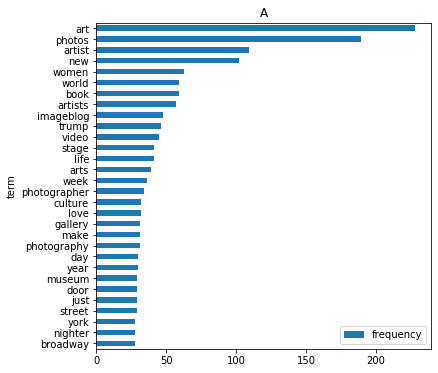

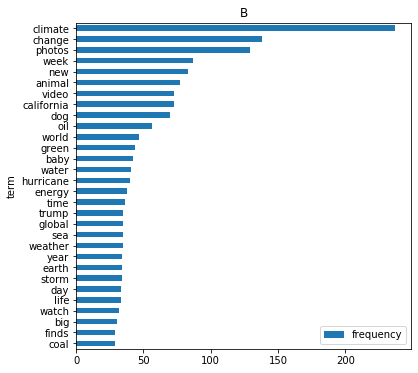

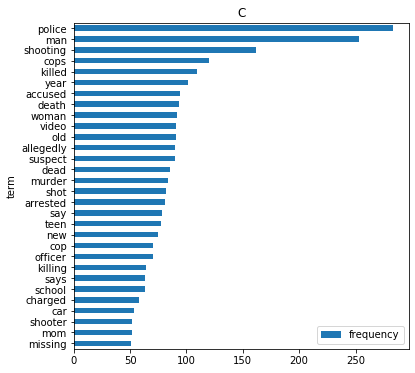

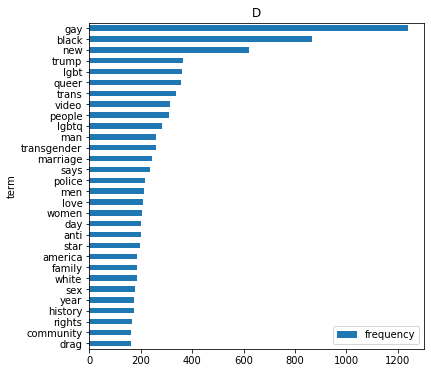

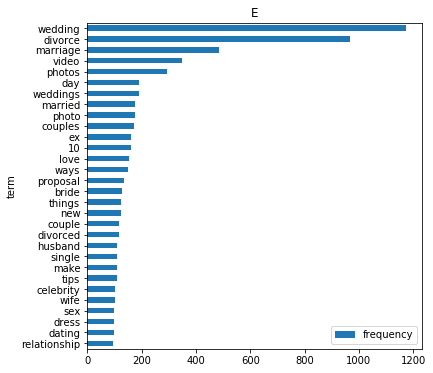

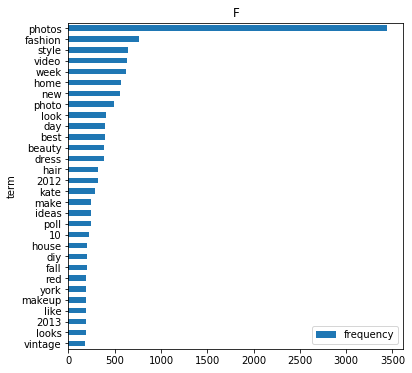

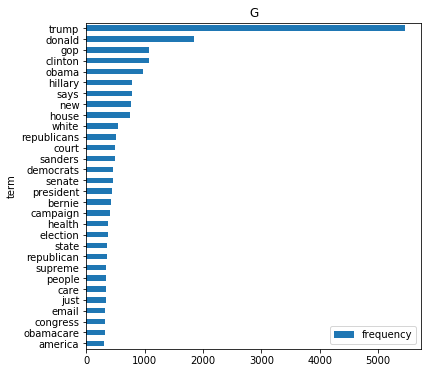

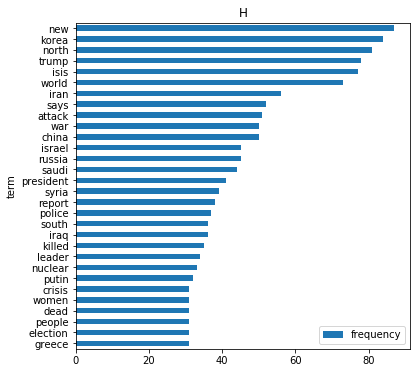

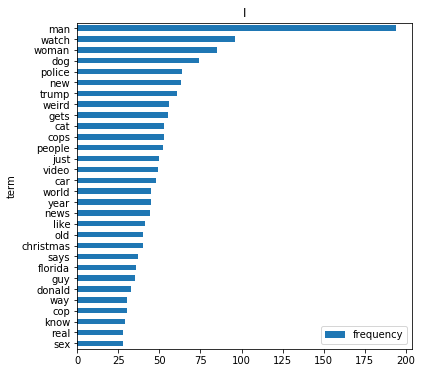

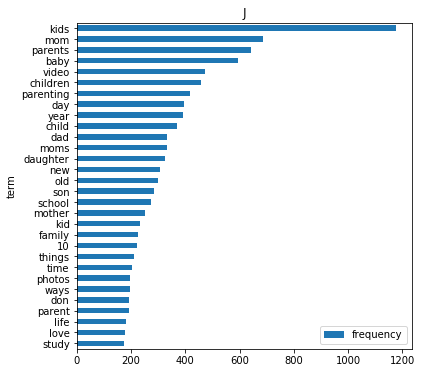

In [53]:
for l in labels: 
  freqTerms = showFreqTerms(headline_vectorizer.transform(df.headline[df.category == l]), headline_vectorizer)[0:30]
  pd.DataFrame(freqTerms, columns = ["term", "frequency"]).set_index("term").sort_values("frequency").plot(kind="barh", title = l )

- Looks like categories map to some of the original Kaggle dataset and they are well defined.

From frequent terms analysis we see that the categories are easy for an human to identify. Nevertheless some of the frequent words do appear in some of the categories (e.g. new, week, year) which is usual. 

TODO: We will look later if we can select more specific terms by using feature/term selection techniques. 



## 5.  Test set vocabulary exploration 

We are going to look at test set to check if same terms are representative here than in training. This may be one of the sources for bad performance. 


In [0]:
plt.rcParams["figure.figsize"] = (6,12)

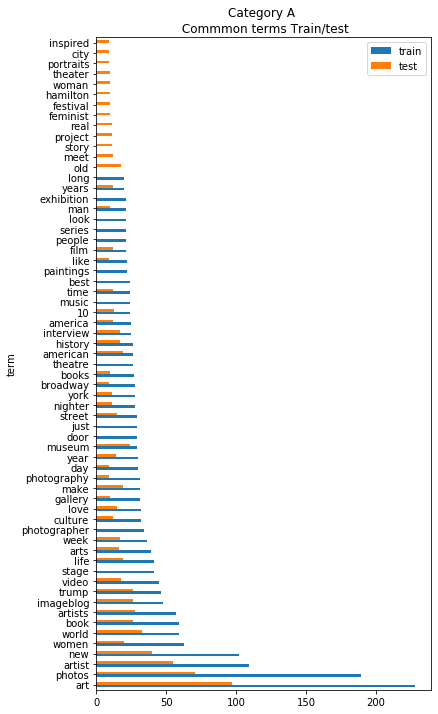

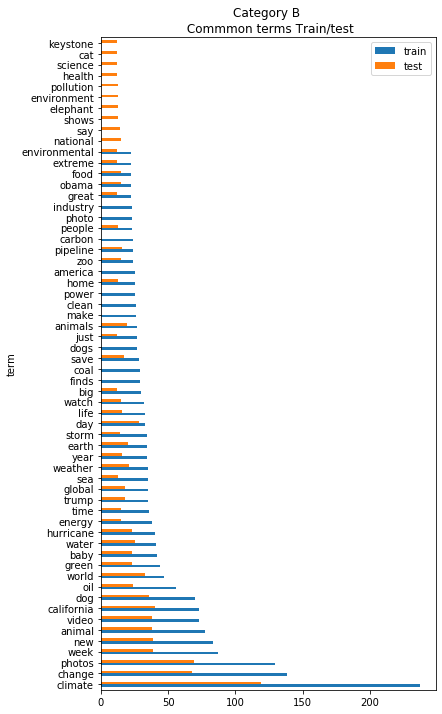

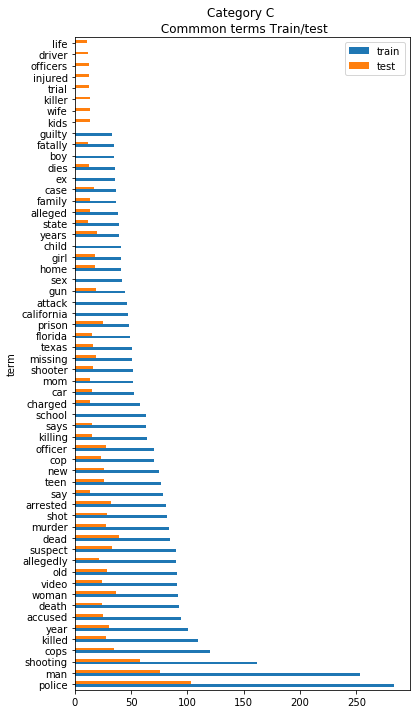

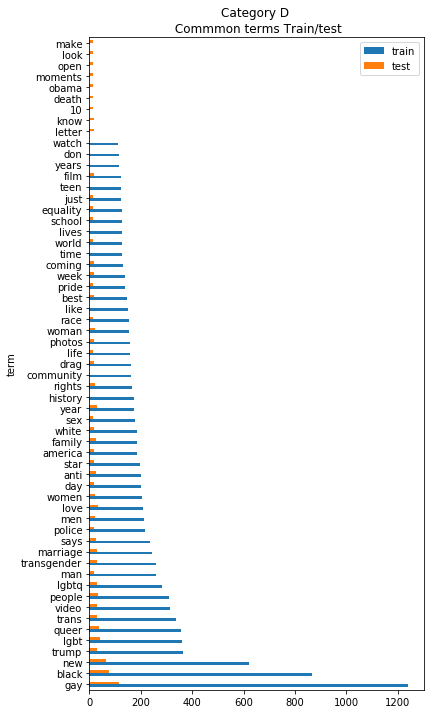

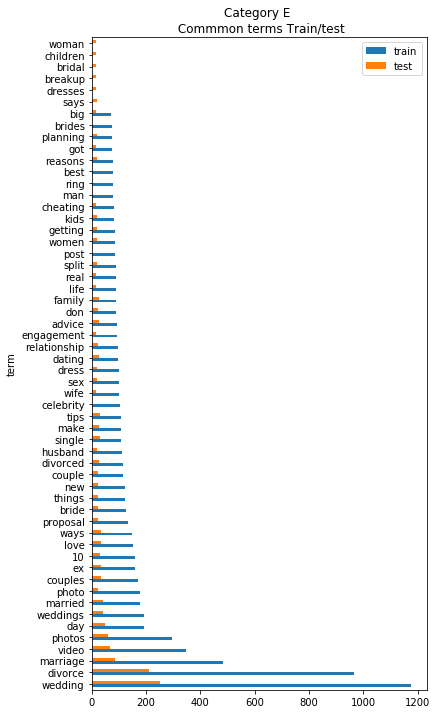

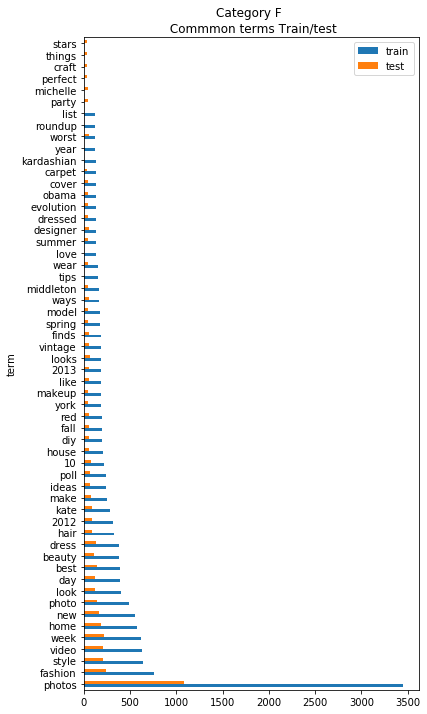

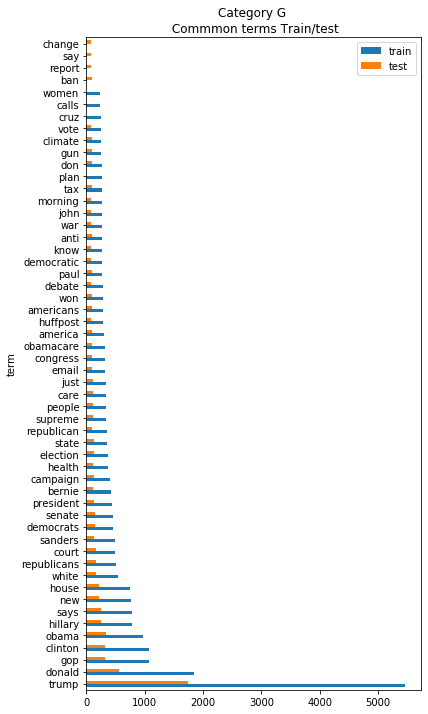

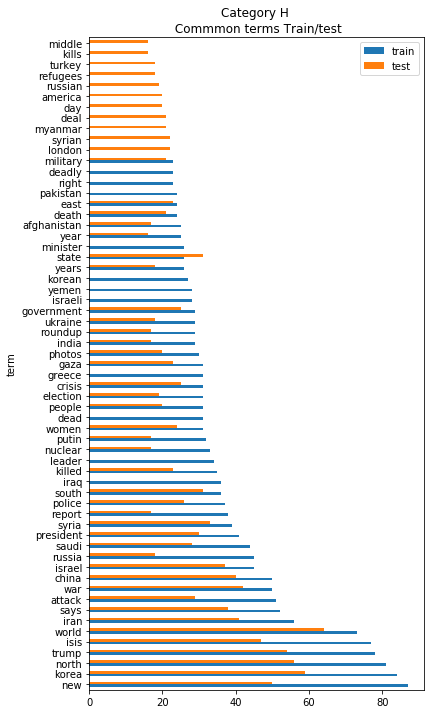

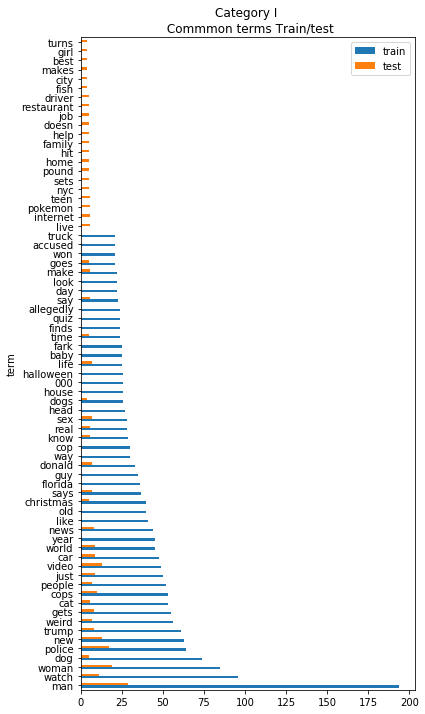

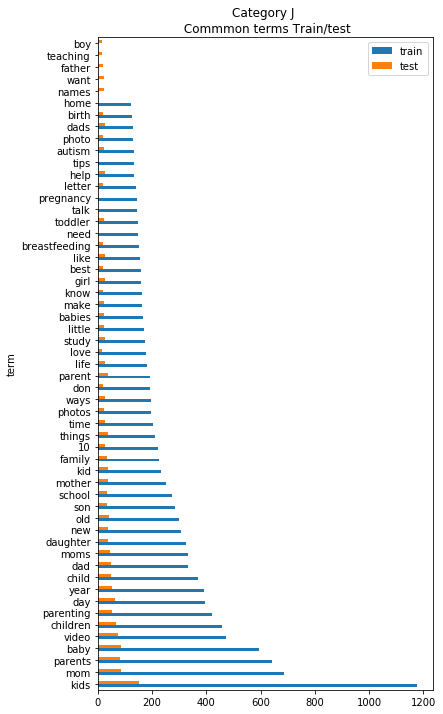

In [90]:
N = 50

for l in labels:
  train_freqTerms = showFreqTerms(headline_vectorizer.transform(df.headline[df.category == l]), headline_vectorizer)[0:N]
  train_freqTerms_df = pd.DataFrame(train_freqTerms, columns = ["term", "train"])

  test_freqTerms = showFreqTerms(headline_vectorizer.transform(X_test.headline[Y_test.category == l]), headline_vectorizer)[0:N]
  test_freqTerms_df = pd.DataFrame(test_freqTerms, columns = ["term", "test"])

  freq_terms_df = train_freqTerms_df.merge(test_freqTerms_df, on='term', how='outer').fillna(0).set_index('term')

  freq_terms_df.plot(kind='barh', title = f"Category {l} \n Commmon terms Train/test" )

## Aside: Explore idea that percentage of feature/term overlap makes a difference in performance. 

In [111]:
 

N = 100

for l in labels: 
  train_freqTerms = showFreqTerms(headline_vectorizer.transform(df.headline[df.category == l]), headline_vectorizer)[0:N]
  train_freqTerms_df = pd.DataFrame(train_freqTerms, columns = ["term", "train"])

  test_freqTerms = showFreqTerms(headline_vectorizer.transform(X_test.headline[Y_test.category == l]), headline_vectorizer)[0:N]
  test_freqTerms_df = pd.DataFrame(test_freqTerms, columns = ["term", "test"])

  freq_terms_df = train_freqTerms_df.merge(test_freqTerms_df, on='term', how='outer').fillna(0).set_index('term')

  n_test_terms_not_matched = freq_terms_df[freq_terms_df["train"] ==  0].shape[0]/freq_terms_df.shape[0]

  print(f" Category {l} - {N} terms: % not matched:  {n_test_terms_not_matched:.2f}")

 Category A - 100 terms: % not matched:  0.22
 Category B - 100 terms: % not matched:  0.24
 Category C - 100 terms: % not matched:  0.17
 Category D - 100 terms: % not matched:  0.17
 Category E - 100 terms: % not matched:  0.16
 Category F - 100 terms: % not matched:  0.15
 Category G - 100 terms: % not matched:  0.05
 Category H - 100 terms: % not matched:  0.20
 Category I - 100 terms: % not matched:  0.32
 Category J - 100 terms: % not matched:  0.14
